# Предсказываем модель кузова

## Часть 1. Работа с моделями и ансамблями моделей в задачи классификации.

### 1. Чтение данных.
Воспользуемся [датасетом](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Vehicle+Silhouettes%29), в котором описываются различные автомобили. Будем решать задачу многоклассовой ($k=4$) классификации.
Для удобства, датасет уже преобразован в удобный формат.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# датасет
dataset = pd.read_csv('https://raw.githubusercontent.com/ml-mipt/ml-mipt/master/homeworks_basic/Lab1_Ensembles_and_SVM/car_data.csv', delimiter=',', header=None).values
# данные
print(pd.DataFrame(dataset))
dataset = shuffle(dataset) #перетасовка помогла увеличить точность
data = dataset[:, :-1].astype(int)
# искомая величина
target = dataset[:, -1]

print(data.shape, target.shape)

# X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.35)
# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


      0    1   2    3    4    5   6   ...   13   14  15  16   17   18    19
0      0   95  48   83  178   72  10  ...  184   70   6  16  187  197   van
1      1   91  41   84  141   57   9  ...  158   72   9  14  189  199   van
2      2  104  50  106  209   66  10  ...  220   73  14   9  188  196  saab
3      3   93  41   82  159   63   9  ...  127   63   6  10  199  207   van
4      4   85  44   70  205  103  52  ...  188  127   9  11  180  183   bus
..   ...  ...  ..  ...  ...  ...  ..  ...  ...  ...  ..  ..  ...  ...   ...
841  841   93  39   87  183   64   8  ...  149   72   7  25  188  195  saab
842  842   89  46   84  163   66  11  ...  176   72   1  20  186  197   van
843  843  106  54  101  222   67  12  ...  200   70   3   4  187  201  saab
844  844   86  36   78  146   58   7  ...  148   66   0  25  190  195  saab
845  845   85  36   66  123   55   5  ...  131   73   1  18  186  190   van

[846 rows x 20 columns]
(846, 19) (846,)


Для первичного анализа может быть полезна библиотека `pandas`. Преобразуем `train` выборку в `pd.DataFrame`.

In [0]:
from sklearn import preprocessing

dataframe = pd.DataFrame(dataset)
dataframe.info()

# First 15 rows of our dataset.
print(dataframe.head(15))

def number_encode_features(init_df):
    result = init_df.copy() # копируем нашу исходную таблицу
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object: # np.object -- строковый тип / если тип столбца - строка, то нужно его закодировать
            encoders[column] = preprocessing.LabelEncoder() # для колонки column создаем кодировщик
            result[column] = encoders[column].fit_transform(result[column]) # применяем кодировщик к столбцу и перезаписываем столбец
    return result, encoders

encoded_dataframe, encoders = number_encode_features(dataframe) # Теперь encoded data содержит закодированные кат. признаки 
encoded_dataframe.head() 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 20 columns):
0     846 non-null object
1     846 non-null object
2     846 non-null object
3     846 non-null object
4     846 non-null object
5     846 non-null object
6     846 non-null object
7     846 non-null object
8     846 non-null object
9     846 non-null object
10    846 non-null object
11    846 non-null object
12    846 non-null object
13    846 non-null object
14    846 non-null object
15    846 non-null object
16    846 non-null object
17    846 non-null object
18    846 non-null object
19    846 non-null object
dtypes: object(20)
memory usage: 132.3+ KB
     0   1   2   3    4    5   6    7   ...   12   13   14  15  16   17   18    19
0   407  91  38  75  136   53   6  144  ...  305  149   69   1   7  186  191  saab
1    88  91  42  84  209   75   6  171  ...  446  161   69   3  12  196  201   bus
2    55  94  36  66  151   61   8  133  ...  265  119   62   9   3  201  208   van


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,407,16,5,28,29,6,4,30,21,2,13,34,91,37,10,1,7,10,10,2
1,88,16,9,37,102,28,4,57,12,3,20,58,207,49,10,3,12,20,20,0
2,55,19,3,20,44,14,6,19,24,1,17,23,57,8,3,9,3,25,27,3
3,825,11,6,37,42,10,6,42,17,3,15,54,144,45,15,0,23,7,9,1
4,109,24,15,32,92,21,4,70,9,5,35,69,250,59,15,5,8,19,14,0


Воспользовавшись методами `describe` и `info` можно получить полезную информацию о датасете.

In [0]:
encoded_dataframe.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000
mean,422.500000,18.679669,11.861702,34.828605,61.574468,14.352246,6.255319,54.212766,14.932624,3.582742,29.985816,56.211584,185.956265,62.507092,13.310875,6.377069,12.588652,12.931442,14.632388,1.469267
std,244.363459,8.225245,6.169866,14.752962,32.295067,5.918283,2.411720,31.934802,7.808595,2.592138,14.483119,28.758063,115.120484,31.964245,6.692506,4.918353,8.900691,6.160768,7.438797,1.111905
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,211.250000,12.000000,7.000000,23.000000,34.000000,10.000000,5.000000,32.250000,7.000000,2.000000,19.000000,36.000000,104.250000,37.000000,8.000000,2.000000,5.000000,8.000000,9.250000,0.000000
50%,422.500000,18.000000,11.000000,33.000000,60.000000,14.000000,6.000000,43.000000,17.000000,3.000000,28.000000,47.500000,150.000000,61.000000,12.500000,6.000000,11.000000,12.000000,16.000000,1.000000
75%,633.750000,25.000000,16.000000,50.000000,88.000000,18.000000,8.000000,83.000000,20.000000,6.000000,41.000000,84.000000,284.000000,86.000000,16.000000,9.000000,19.000000,17.000000,20.000000,2.000000
max,845.000000,43.000000,26.000000,62.000000,133.000000,36.000000,20.000000,130.000000,34.000000,12.000000,65.000000,127.000000,423.000000,142.000000,38.000000,22.000000,40.000000,29.000000,30.000000,3.000000


### 2. Работа с данными, построение модели, анализ ошибки.

#### 2.1. Предобработка данных.


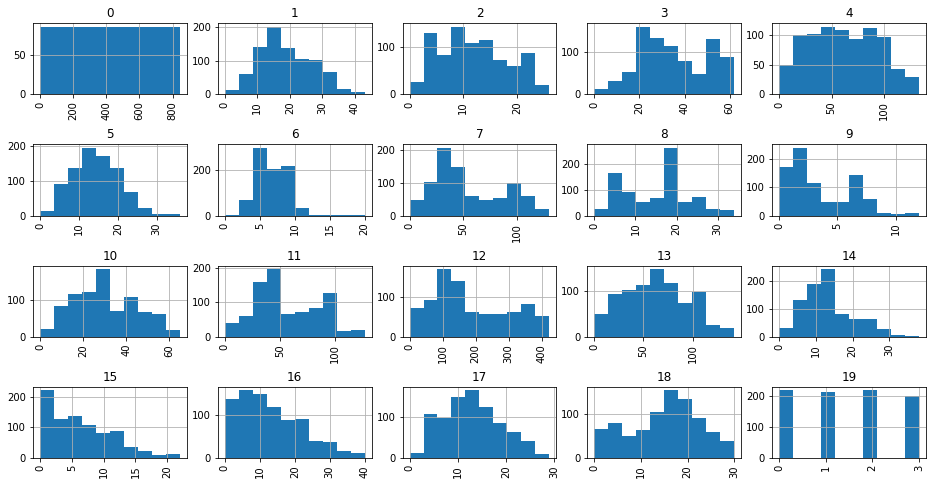

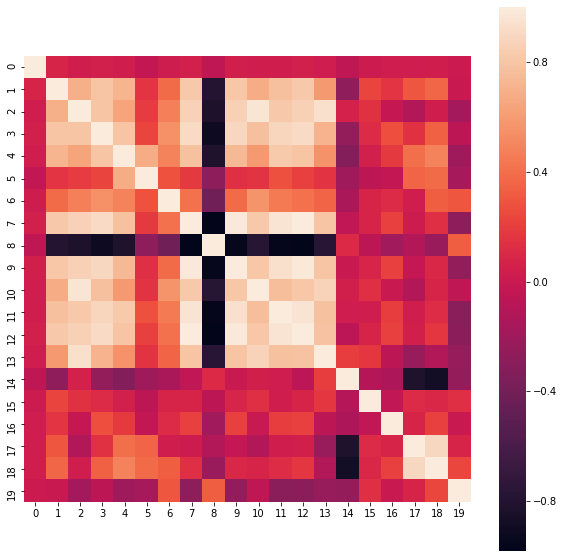

Здесь мы можем видеть, что некоторые столбцы имеют почти единичную корреляцию и их можно удалить,
         что бы наши данные имели более чистый вид и понизить вычислительную сложность


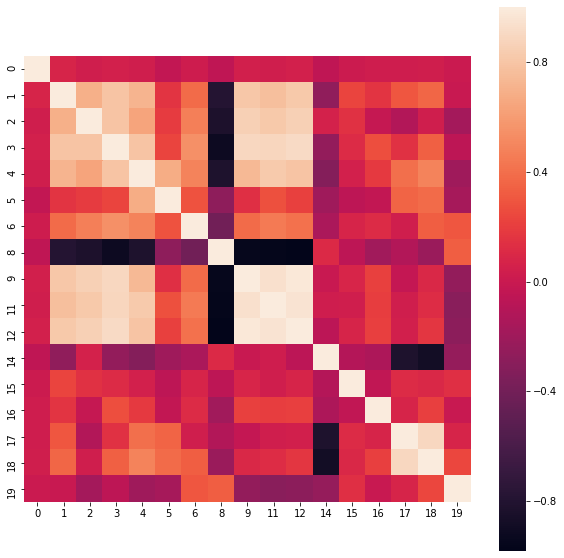


В числовом виде - таблица


,0,1,2,3,4,5,6,8,9,11,12,14,15,16,17,18,19
0,1.000000,0.077373,0.037467,0.048574,0.034504,-0.029973,0.018047,-0.050146,0.047815,0.035631,0.054208,-0.049079,0.014916,0.031383,0.025818,0.032951,0.009053
1,0.077373,1.000000,0.693067,0.792775,0.719525,0.162796,0.382657,-0.788970,0.813873,0.774094,0.815802,-0.267327,0.233242,0.157260,0.297632,0.365389,-0.000625
2,0.037467,0.693067,1.000000,0.796345,0.639884,0.190672,0.473284,-0.828778,0.857925,0.819361,0.856043,0.061831,0.148433,-0.015346,-0.113017,0.038677,-0.174246
3,0.048574,0.792775,0.796345,1.000000,0.797788,0.227221,0.549641,-0.911570,0.894543,0.886522,0.910709,-0.251094,0.116935,0.265905,0.148526,0.335354,-0.054465
4,0.034504,0.719525,0.639884,0.797788,1.000000,0.678252,0.485988,-0.822902,0.740253,0.823486,0.794771,-0.322230,0.055795,0.181223,0.400488,0.488565,-0.192171
5,-0.029973,0.162796,0.190672,0.227221,0.678252,1.000000,0.287451,-0.271493,0.138033,0.274382,0.212266,-0.194976,-0.055145,-0.031641,0.357467,0.380945,-0.162904
6,0.018047,0.382657,0.473284,0.549641,0.485988,0.287451,1.000000,-0.407050,0.385446,0.449856,0.407279,-0.140494,0.071889,0.112072,0.034871,0.331369,0.301259
8,-0.050146,-0.788970,-0.828778,-0.911570,-0.822902,-0.271493,-0.407050,1.000000,-0.950664,-0.959330,-0.981206,0.107356,-0.053540,-0.185299,-0.112051,-0.216550,0.326955
9,0.047815,0.813873,0.857925,0.894543,0.740253,0.138033,0.385446,-0.950664,1.000000,0.943646,0.982874,-0.004384,0.082346,0.213062,-0.021950,0.098519,-0.249787
11,0.035631,0.774094,0.819361,0.886522,0.823486,0.274382,0.449856,-0.959330,0.943646,1.000000,0.959431,0.025231,0.038659,0.198892,0.033780,0.122814,-0.299557


In [0]:
# Построим графики что бы увидеть распределение величин
fig = plt.figure(figsize=(16,8))
cols = 5

rows = np.ceil(float(encoded_dataframe.shape[1]) / cols)
for i, column in enumerate(encoded_dataframe.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_dataframe[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

# Посмотрим, какие присутствуют корреляции
def show_heat_map(dataframe):
  plt.subplots(figsize=(10,10))
  sns.heatmap(dataframe.corr(), square=True)
  plt.show()

show_heat_map(encoded_dataframe)

# Добавление столбцов явно помогло при удалении столбцов с близкой к единичной корреляцией
columns = ('0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19')
encoded_dataframe.columns = columns.split()

print('''Здесь мы можем видеть, что некоторые столбцы имеют почти единичную корреляцию и их можно удалить,
         что бы наши данные имели более чистый вид и понизить вычислительную сложность''')
encoded_dataframe.drop(columns=['7', '10', '13'], axis=0, inplace=True)

#Выведем ещё раз тепловую карту для наглядности
show_heat_map(encoded_dataframe)

print('\nВ числовом виде - таблица')
encoded_dataframe.corr()


In [0]:
# Посмотрим на уникальные значения целевой переменной
# print(set(target))

# Закодируем их one-hot. Данный метод лучше воспринимается алгоритмами
# target = pd.get_dummies(target)
# target

# Выделим целвую переменную
y = encoded_dataframe['19'].values
print(y)

encoded_dataframe.drop(['19'], axis=1, inplace = True)

[2 0 3 1 0 0 0 1 0 0 2 3 3 0 2 2 0 3 0 1 1 0 2 3 0 0 0 2 1 3 0 2 2 1 1 0 1
 0 3 1 1 2 2 1 1 2 0 0 3 3 2 2 0 2 0 1 1 3 1 3 3 3 1 0 0 3 0 3 3 1 3 1 0 2
 2 2 0 3 1 2 1 1 2 3 2 0 0 1 1 0 3 1 2 3 0 0 3 3 1 3 0 3 0 1 3 0 3 3 3 0 1
 1 1 3 2 2 1 3 2 2 3 0 3 0 0 1 1 3 3 3 2 1 2 2 0 3 1 3 3 1 3 1 0 0 0 1 0 0
 2 1 3 1 0 0 1 1 2 0 3 2 2 1 0 0 2 0 1 0 0 3 2 3 2 1 2 1 0 1 0 2 3 3 1 3 2
 0 0 2 3 0 1 3 3 1 2 2 0 2 1 3 0 2 0 3 2 3 2 1 3 2 1 1 3 0 1 3 0 0 3 1 1 0
 2 1 2 3 3 2 3 1 2 1 0 2 3 0 0 3 0 0 0 1 0 3 0 0 1 2 0 2 2 0 2 1 1 2 3 0 2
 1 3 1 3 2 0 2 3 3 1 3 0 0 0 0 2 2 2 2 1 1 2 2 2 1 0 0 1 1 1 2 0 3 0 0 3 2
 3 3 2 1 1 2 1 1 3 1 1 0 2 0 0 0 0 1 2 1 0 1 2 1 3 2 0 0 0 3 1 1 1 2 3 1 0
 3 0 3 2 3 0 1 2 0 2 1 3 1 1 3 1 0 1 0 1 3 3 0 2 0 1 1 3 1 2 3 1 3 0 3 1 2
 1 1 0 2 2 1 0 0 2 0 2 0 1 3 2 3 0 1 0 3 0 0 2 1 0 1 3 1 2 2 1 3 3 1 0 3 1
 0 1 2 3 1 3 0 1 0 0 0 2 0 1 1 2 3 2 1 3 2 2 1 3 3 2 2 1 0 2 3 1 0 1 1 1 2
 2 3 0 3 1 1 0 2 3 0 0 1 3 0 1 0 3 1 1 0 2 3 2 1 3 2 0 0 1 0 0 0 3 2 2 1 1
 3 3 2 0 2 0 1 1 2 0 3 3 

In [0]:
# Нормализуем данные

X = encoded_dataframe.values.astype(np.float)
print(X, '\n')

sc = sklearn.preprocessing.StandardScaler()
X = sc.fit_transform(X)
X

[[407.  16.   5. ...   7.  10.  10.]
 [ 88.  16.   9. ...  12.  20.  20.]
 [ 55.  19.   3. ...   3.  25.  27.]
 ...
 [695.  17.   8. ...  19.   6.   3.]
 [805.   6.  10. ...   2.   6.   4.]
 [304.  10.  12. ...   5.   5.   5.]] 



array([[-0.06346763, -0.32597862, -1.11278941, ..., -0.62826112,
        -0.47610563, -0.62310178],
       [-1.36967234, -0.32597862, -0.46409357, ..., -0.06617471,
         1.1480289 ,  0.72199673],
       [-1.50479697,  0.03896789, -1.43713733, ..., -1.07793025,
         1.96009616,  1.6635657 ],
       ...,
       [ 1.11580183, -0.20432978, -0.62626753, ...,  0.72074626,
        -1.12575944, -1.56467075],
       [ 1.56621725, -1.54246698, -0.30191961, ..., -1.19034753,
        -1.12575944, -1.4301609 ],
       [-0.48522025, -1.05587164,  0.02242831, ..., -0.85309568,
        -1.2881729 , -1.29565104]])

In [0]:
# Разделим на train и test выборки наши данные после того, как мы их обработали

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=0)
print(X_train)
print(y_train)
print('\n', X_test)
print(y_test)



# Стоит ли препроцессинг делать после разделения разделения на трейн и тест?
# from sklearn.preprocessing import StandardScaler
# from sklearn import preprocessing
# X_train = preprocessing.scale(X_train)

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

[[ 2.04734281e-03 -1.05587164e+00  2.24283137e-02 ... -9.65512964e-01
  -1.28817290e+00 -1.56467075e+00]
 [-1.35738828e+00  3.89678897e-02 -1.11278941e+00 ...  2.71077133e-01
   1.73548181e-01 -8.50623768e-02]
 [ 1.11580183e+00 -2.04329783e-01 -6.26267528e-01 ...  7.20746259e-01
  -1.12575944e+00 -1.56467075e+00]
 ...
 [-1.62763753e+00 -1.05587164e+00  2.24283137e-02 ... -9.65512964e-01
  -1.51278725e-01  4.52977031e-01]
 [ 1.02367141e-02 -5.69276292e-01 -1.43713733e+00 ...  2.63184005e+00
   6.60788541e-01  9.91016439e-01]
 [-6.14202843e-03  5.25563235e-01  5.08950195e-01 ... -6.28261120e-01
   1.11347285e-02  4.94474751e-02]]
[0 1 3 3 2 1 0 3 1 1 1 1 1 2 2 3 3 2 1 1 1 3 1 3 1 3 1 2 0 0 0 1 3 2 3 1 2
 1 1 2 3 3 2 2 3 0 0 0 3 2 1 0 3 2 2 1 2 2 1 0 1 1 0 0 2 2 2 3 3 2 3 2 2 0
 0 2 1 2 0 3 0 0 3 1 2 0 1 0 1 3 0 2 3 0 3 0 3 1 2 3 1 3 3 0 3 1 2 0 1 2 2
 3 0 1 0 3 0 3 0 1 2 1 2 3 3 0 0 3 3 2 3 2 2 0 1 0 2 3 3 0 0 0 0 3 3 2 3 2
 1 0 3 1 3 2 1 1 3 2 2 1 0 1 2 2 3 0 1 2 0 1 0 3 0 1 2 0 0 2 3 2

#### 2.2. Логистическая регрессия.
* Подберём оптимальные параметры логистической регресии с помощью кросс-валидации на train-датасете

* Построим график ROC-кривой для данного классификатора (`sklearn.metrics.roc_curve`), оценим точность классификации и f1-score. ([несколько рок кривых в примере](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py))

In [0]:
# Импортируем библиотеки
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

print(X_train.shape)
print(y_train.shape)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

# Создадим экземпляр класса логистической регрессии и передадим в него обучающие выборки
logreg = LogisticRegression()
logreg.fit(X_train, y_train)


(549, 16)
(549,)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred = logreg.predict(X_test) 
print('Точность классификатора логистической регрессии на test set: {:.2f}'.format(logreg.score(X_test, y_test)))

#Построим confusion matrix что бы увидеть точность по TP TN FP FN
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix, '\n')

# Выведем метрики нашего классификатора
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Точность классификатора логистической регрессии на test set: 0.77
[[72  1  3  0]
 [ 2 40 24  6]
 [ 4 25 45  3]
 [ 1  0  0 71]] 

              precision    recall  f1-score   support

           0       0.91      0.95      0.93        76
           1       0.61      0.56      0.58        72
           2       0.62      0.58      0.60        77
           3       0.89      0.99      0.93        72

    accuracy                           0.77       297
   macro avg       0.76      0.77      0.76       297
weighted avg       0.76      0.77      0.76       297



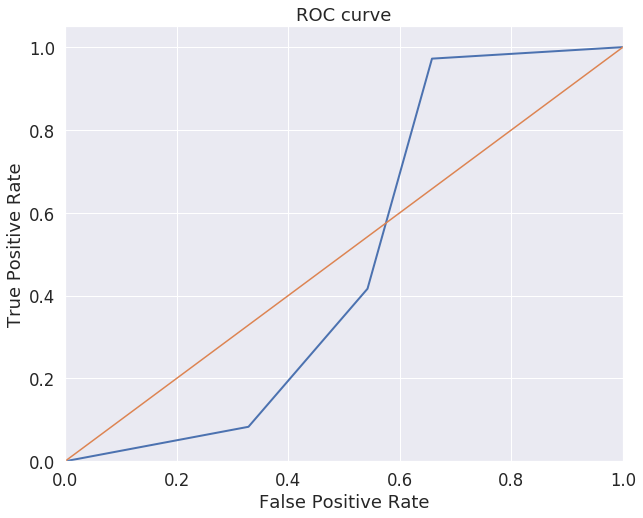

In [0]:
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import roc_curve
# logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
# fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
# plt.figure()
# plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc) # посмотреть позже
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
# plt.show()

# Построим ROC кроивую для оценки модели в целом
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
# Передадим целевой столбец ответом и результат классификатора
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
lw = 2

# Зададим параметры отображения
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [0]:
from sklearn.linear_model import LogisticRegressionCV

# Всё равно, даже после препроцессинга получаю сообщение с просьбой увеличения
# итераций хотя из уже 210 или с предложениями препроцессинга. 
# Increase the number of iterations (max_iter) or scale the data

from sklearn import preprocessing
X_scaled = preprocessing.scale(X_train)
print(X_scaled.shape)

# Скормим данные на которых она будет учиться
logReg_cv = LogisticRegressionCV(cv=5, random_state=0, max_iter=210).fit(X_scaled, y_train)


(549, 16)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [0]:
# Выведем точность классификатора данной модели после кросс валидации

print('Оценка логистической регрессии:')
y_pred_cv = logReg_cv.predict(X_test)
print(logReg_cv.score(X_test, y_test))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix, '\n')

print(classification_report(y_test, y_pred_cv))

print('\nКак можем видеть точность выше чем у модели без кросс валидации')

Оценка логистической регрессии:
0.7912457912457912
[[72  1  3  0]
 [ 2 40 24  6]
 [ 4 25 45  3]
 [ 1  0  0 71]] 

              precision    recall  f1-score   support

           0       0.97      0.91      0.94        76
           1       0.62      0.62      0.62        72
           2       0.66      0.65      0.65        77
           3       0.91      0.99      0.95        72

    accuracy                           0.79       297
   macro avg       0.79      0.79      0.79       297
weighted avg       0.79      0.79      0.79       297


Как можем видеть точность выше чем у модели без кросс валидации


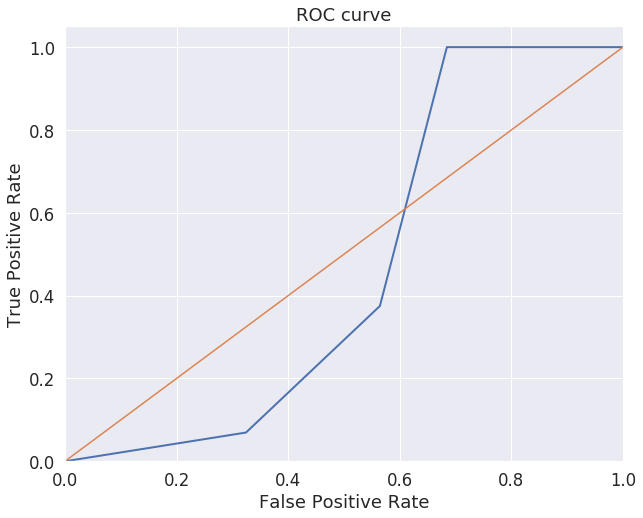

In [0]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
# Передадим целевой столбец ответом и результат классификатора
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_cv, pos_label=1)
lw = 2

# Зададим параметры отображения
plt.plot(fpr, tpr, lw=lw, label='ROC curve after Cross Validation')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

#### 2.3. Решающее дерево.
Рассмотрим поведение решающего дерева на исходных и преобразованных данных. Будем варьировать лишь один параметр - максимальную глубину дерева. 

* С помощью кросс-валидации подберём оптимальный параметр `max_depth` и оценим на исходных и преобразованных данных те же метрики, что и выше.

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Создадим экземпляр решающего дерева и обучим его
classif_tree = DecisionTreeClassifier(criterion = 'entropy', min_samples_split=50) 
classif_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
from sklearn.metrics import accuracy_score

# Предскажем значения
y_pred =  classif_tree.predict(X_test)

print('Точность модели на тестовых данных: ', accuracy_score(y_true=y_test, y_pred=y_pred))

Точность модели на тестовых данных:  0.6363636363636364


In [0]:
# Используем кросс валидацию для поиска оптимальной глубины 'max_depth'
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':range(3,20)}
classif_tree_cv = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
classif_tree_cv.fit(X_train, y_train)
tree_model = classif_tree_cv.best_estimator_
print (classif_tree_cv.best_score_, classif_tree_cv.best_params_) 

y_pred_tree_cv = classif_tree_cv.predict(X_test)
print('Точность модели на тестовых данных: ', accuracy_score(y_true=y_test, y_pred=y_pred_tree_cv))
print('Точность при кросс валидации имеет немного лучшие показатели чем просто на разделённой выборке')

0.7067389491242702 {'max_depth': 7}
Точность модели на тестовых данных:  0.6801346801346801
Точность при кросс валидации имеет немного лучшие показатели чем просто на разделённой выборке


#### 2.4. Bagging. 

Перейдем к ансамблям. 

Для построения ансамбля воспользуемся Bagging'ом с числом алгоритмов от 2 до 50. В качестве первого семейства базовых алгоримтов будем использовать линейные модели (т.е. логистическую регрессию), в качестве второго - решающие деревья. 

Для этого можно сгенерировать с помощью метода bootstrap 50 подвыборок из `train` выборки (того же размера, что и исходная), обучить логистическую регрессию и решающее дерево с оптимальными параметрами из предыдущего пункта на каждой из подвыборок и затем усреднить предсказания k моделей.

*Hint: в sklearn может найтись подходящая функция, которая облегчит нам реализацию данного пункта.*

Построим график качества классификации.

0.6498316498316499

Метод:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

               precision    recall  f1-score   support

           0       0.91      0.91      0.91        78
           1       0.54      0.65      0.59        66
           2       0.67      0.49      0.57        87
           3       0.85      0.97      0.91        66

    accuracy                           0.74       297
   macro avg       0.74      0.76      0.74       297
weighted avg       0.74      0.74      0.74       297

Score:  0.7441077441077442

Метод:  BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

               precision    recall  f1-score   support

           0       0.67      0.15      0.25  

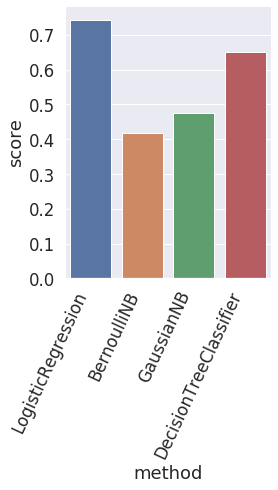

In [0]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=100, n_features=4,
#                             n_informative=2, n_redundant=0,
#                             random_state=0, shuffle=False)

# clf = BaggingClassifier(base_estimator=SVC(),
#                          n_estimators=10, random_state=0).fit(X, y)


# Зададим параметры решающего дерева
dtc = DecisionTreeClassifier(criterion="entropy", min_samples_split=50)
bag_model=BaggingClassifier(base_estimator=dtc, n_estimators=100, bootstrap=True)
bag_model=bag_model.fit(X_train, y_train)
y_test_pred=bag_model.predict(X_test) # предсказание
print(bag_model.score(X_test, y_test))
# print(confusion_matrix(y_test, y_test_pred)) 

# Используем разные методы
lr = LogisticRegression();
bnb = BernoulliNB()
gnb = GaussianNB()

base_methods=[lr, bnb, gnb, dtc]
scores = []
output_method_names = []

# Пройдёмся по разным методам и отобразим из точность
for bm  in base_methods:
 print("\nМетод: ", bm)
 bag_model=BaggingClassifier(base_estimator=bm, n_estimators=100, bootstrap=True)
 bag_model=bag_model.fit(X_train, y_train)
 y_test_pred=bag_model.predict(X_test)
 print('\n',classification_report(y_test, y_test_pred))
 model_score = bag_model.score(X_test, y_test)
 print('Score: ', model_score)
 scores.append(model_score)

#  print(confusion_matrix(y_test, y_test_pred)) 

for bm in base_methods:
  name, _ = str(bm).split('(')
  output_method_names.append(name)

scores_df = pd.DataFrame(list(zip(output_method_names, scores)), 
                         columns=['method', 'score'])

print(scores_df) #Наш датафрейм для красивого отображения
    
# Отобразим график алгоритма к его оценке
chart = sns.catplot(x='method', y='score', kind="bar", data=scores_df);

chart.set_xticklabels(rotation=65, horizontalalignment='right')


#### 2.5. Random Forest.
Теперь воспользуйтесь `sklearn`-реализацией алгоритма Random Forest. 

* Построим аналогичные графики для него (изменяя число деревьев от 1 до 50). Остальные параметры можно оставить по умолчанию.

* Проанализируем полученные результаты.

In [0]:
# Импорт модели, которую будем использовать
from sklearn.ensemble import RandomForestRegressor
# Инстанциируем модель с 1000 деревьями решений
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Натренируем модель на train данных
rf.fit(X_train, y_train);

In [0]:
# Используем метод предсказания 'леса' на тестовых данных
predictions = rf.predict(X_test)
# Высчитаем абсолютные ошибки
errors = abs(predictions - y_test)
# Высчитаем среднюю абсолютную ошибку (mae)
print('Average Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Average Absolute Error: 0.41 degrees.


In [0]:
# Высчитаем среднюю абсолютную ошибку (MAPE)
mape = 100 * (errors / y_test)
# Высчитаем и отобразим точность
accuracy = 100 - np.mean(mape)
print(mape)
print(accuracy)
# Выкинем nan
print('Accuracy:', round(accuracy, 2), '%.')

[7.86666667e+00 3.01000000e+01 1.81000000e+01 3.92000000e+01
 1.46666667e+00 4.96666667e+00 1.83500000e+01 2.55000000e+01
 5.72000000e+01 7.06000000e+01            inf 6.20000000e+00
            inf 3.80000000e+01            inf 6.55000000e+00
 1.17000000e+01 1.58800000e+02 3.41000000e+01 2.33000000e+01
 3.84000000e+01            inf 0.00000000e+00 5.93333333e+00
            inf 3.98500000e+01            inf 3.58000000e+01
            inf 9.80000000e+00            inf 1.87000000e+01
 4.67500000e+01            inf 1.11000000e+01 3.30000000e+00
            inf 4.64000000e+01            inf 1.46666667e+00
 5.77000000e+01 3.65500000e+01 1.73000000e+02 4.40000000e+00
 1.46500000e+01 6.57000000e+01            inf            inf
 4.07000000e+01 4.39500000e+01 1.07000000e+01            inf
            inf 6.13333333e+00 5.31000000e+01 1.08000000e+01
            inf            inf            inf 9.20000000e+00
 1.04666667e+01 3.19500000e+01 8.57000000e+01 3.39500000e+01
 1.39500000e+01 6.006666

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [0]:
# Импортируем инструменты для визуализации
from sklearn.tree import export_graphviz
import pydot# Вытащить одно дерево из леса
tree = rf.estimators_[5]

feature_list = list(encoded_dataframe.columns)

tree = rf.estimators_[5]# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)# используем dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')# Запишем в пнг файл
graph.write_png('tree.png')

In [0]:
from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

regressor = RandomForestRegressor(n_estimators=1200, random_state=100)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

errors = abs(y_pred - y_test)
# Отобразим обученную на расширенных данных
print('Average absolute error: ', round(np.mean(errors), 2), 'degrees.')
print('Mean Asolute Percentage Error')
mape = np.mean(100 * (errors / y_test))


# Отобразим наши метрики
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# print(confusion_matrix(y_test,y_pred))
# print(classification_report(y_test,y_pred))
# print(accuracy_score(y_test, y_pred))

Average absolute error:  0.41 degrees.
Mean Asolute Percentage Error
Mean Absolute Error: 0.40978675645342316
Mean Squared Error: 0.3423174335952114
Root Mean Squared Error: 0.5850789977389476


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


#### 2.6 KNN

Постоим алгоритм KNN


In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Объявем кнн классификатор
knn = KNeighborsClassifier()
knn_grid = {'n_neighbors': np.array(np.linspace(1, 60), dtype='int')} 

#Зададим параметры кросс валидации
gs = GridSearchCV(knn, knn_grid, cv=24)
gs.fit(X, y)

GridSearchCV(cv=24, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 19, 20,
       21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 37, 38, 39, 40,
       41, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
# Зададим функцию отрисовки
def grid_plot(x, y, x_label, title, y_label='roc_auc'):
    plt.figure(figsize=(12, 6))
    plt.grid(True)
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

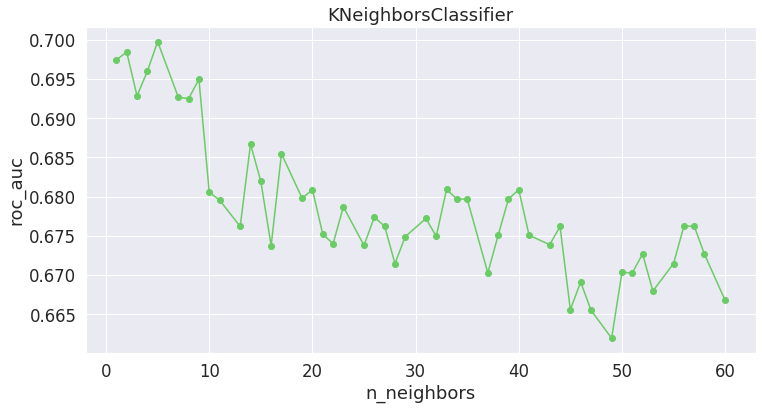

In [0]:
grid_plot(knn_grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

In [0]:
print(gs.best_params_, gs.best_score_)

{'n_neighbors': 5} 0.6997685185185185


In [0]:
knn = KNeighborsClassifier(n_neighbors=45) #gs.best_model
clf_knn = knn.fit(X_train, y_train)

y_knn = clf_knn.predict(X_test)
y_knn

array([1, 1, 0, 2, 0, 0, 0, 0, 3, 0, 1, 1, 0, 3, 0, 1, 3, 3, 3, 1, 0, 0,
       3, 1, 1, 0, 0, 3, 2, 3, 2, 0, 0, 0, 1, 3, 0, 3, 1, 1, 1, 0, 3, 3,
       0, 0, 2, 0, 0, 0, 2, 1, 0, 1, 0, 3, 0, 0, 0, 0, 3, 3, 2, 1, 3, 0,
       0, 3, 0, 3, 0, 0, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 0, 2, 1, 3, 2, 3,
       2, 2, 2, 1, 1, 2, 2, 0, 2, 1, 3, 0, 2, 2, 0, 3, 3, 2, 0, 2, 0, 2,
       1, 3, 2, 3, 2, 2, 1, 2, 3, 2, 0, 3, 0, 0, 1, 2, 0, 1, 0, 3, 2, 0,
       0, 0, 1, 0, 3, 3, 3, 1, 2, 3, 3, 1, 2, 0, 1, 3, 3, 0, 2, 0, 0, 2,
       3, 3, 3, 3, 1, 0, 2, 0, 3, 3, 0, 1, 3, 3, 1, 3, 3, 3, 3, 0, 0, 2,
       2, 1, 0, 3, 3, 2, 0, 0, 2, 0, 3, 0, 2, 2, 0, 3, 0, 3, 2, 3, 1, 0,
       1, 1, 2, 3, 0, 1, 0, 3, 0, 3, 2, 0, 1, 3, 2, 3, 0, 2, 2, 2, 3, 0,
       0, 0, 0, 0, 0, 1, 3, 0, 3, 0, 2, 0, 1, 1, 3, 1, 1, 0, 0, 0, 3, 1,
       1, 0, 3, 3, 3, 0, 0, 3, 3, 1, 1, 3, 1, 3, 0, 0, 2, 2, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 3, 2, 0, 3, 3, 1, 0, 3, 3, 0, 3, 3, 3, 1, 3, 1, 1,
       0, 0, 2, 0, 3, 3, 3, 0, 0, 0, 2])

In [0]:
from sklearn import metrics

print ('knn =', metrics.accuracy_score(y_test, y_knn), '\n')
print(metrics.classification_report(y_test, y_knn))

knn = 0.6296296296296297 

              precision    recall  f1-score   support

           0       0.69      0.95      0.80        76
           1       0.53      0.36      0.43        77
           2       0.48      0.37      0.42        76
           3       0.72      0.87      0.79        68

    accuracy                           0.63       297
   macro avg       0.61      0.64      0.61       297
weighted avg       0.60      0.63      0.60       297



In [0]:
# Параметры f1 метрики
print('macro = ', metrics.f1_score(y_test, y_knn, average='macro'), ', micro = ', metrics.f1_score(y_test, y_knn, average='micro'))


macro =  0.6088365862992728 , micro =  0.6296296296296297


#### 2.7 Нейросеть

**Это бонусное задание, делать его не обязательно, но желательно - можно получить лишние баллы.**

Постойте нейросеть на 'train' части. 

* Отобразите столбцевую диаграмму (bar chart) для f1-score и accuracy по результатам тестовой выборки.

* Проанализируйте полученный график. Какие выводы из этого можно получить? Какой алгоритм из построенных за все творческое оказался лучшим?

По желанию:

Попробуйте подобрать перебором параметров сети в цикле, релизуйте код для сохранения лучшей модели. Тут вам поможет:

* https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model
* https://machinelearningmastery.com/save-load-keras-deep-learning-models/
* А лучше всего динамически сохранять лучшие веса лучших моделей в лучших эпохах: https://machinelearningmastery.com/check-point-deep-learning-models-keras/

Кому интересно далее в deep learning: https://www.youtube.com/playlist?list=PLQVvvaa0QuDfhTox0AjmQ6tvTgMBZBEXN

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

tf.keras.backend.clear_session()  # Для чистого/простого сброса состояния notebook.


In [0]:
from tensorflow import keras
from tensorflow.keras import layers

# Подготовим данные для модели
inputs = keras.Input(shape=(16), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)

# Поместим данные в модель
model = keras.Model(inputs=inputs, outputs=outputs)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:

# Специфицируем обучающую конфигурацию метрики, потери, оптимизатор
model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
              # Loss function to minimize
              loss=keras.losses.SparseCategoricalCrossentropy(),
              # List of metrics to monitor
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

# Train the model by slicing the data into "batches"
# of size "batch_size", and repeatedly iterating over
# the entire dataset for a given number of "epochs"
print('# Fit model on training data')
# history = model.fit(X_train, y_train,
#                     batch_size=64,
#                     epochs=3,
                    # Добавил валидацию для мониторинга потерь и метрик в конце эпох
                    # validation_data=(x_val, y_val))
history = model.fit(x=X, y=y, batch_size=None, epochs=1,
                   verbose=1, callbacks=None, validation_split=0.0,
                   validation_data=None, shuffle=True, class_weight=None, 
                   sample_weight=None, initial_epoch=0, steps_per_epoch=None, 
                   validation_steps=None, validation_freq=1, max_queue_size=10,
                   workers=1, use_multiprocessing=False)


# Возвращённый объект "Истории" имеет записи значний
# потерь и метрики значения в ходе обучения
print('\nhistory dict:', history.history)

# Оценим модель на тестовых данных используя `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(X, y, batch_size=128)
print('test loss, test acc:', results)

# Генерируем предсказания (вероятность -- вывод последнего слоя)
# используем `predict` на новых данных
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test[:4])
print('predictions shape:', predictions.shape)


# Fit model on training data
Train on 846 samples
846/846 [==============================] - 0s 106us/sample - loss: 0.8892 - sparse_categorical_accuracy: 0.9255

history dict: {'loss': [0.8892123001510687], 'sparse_categorical_accuracy': [0.9255319]}

# Evaluate on test data
846/846 [==============================] - 0s 36us/sample - loss: 0.7000 - sparse_categorical_accuracy: 0.9326
test loss, test acc: [0.7000154130002285, 0.9326241]

# Generate predictions for 3 samples
predictions shape: (4, 10)


In [0]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(12, input_dim=16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# скомпилируем keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [0]:
# Скормим keras модели наши данные

X_train_keras, X_test_keras, y_train_keras, y_test_keras = train_test_split(X, y, test_size=0.35, random_state=0)
model.fit(X_train_keras, y_train_keras, epochs=400, batch_size=10) # Сделаем колличество эпох обучения 400 что бы лучше обучить модель

Train on 549 samples
Epoch 1/400
549/549 [==============================] - 0s 140us/sample - loss: 1.0491 - sparse_categorical_accuracy: 0.6521
Epoch 2/400
549/549 [==============================] - 0s 131us/sample - loss: 0.7697 - sparse_categorical_accuracy: 0.7049
Epoch 3/400
549/549 [==============================] - 0s 120us/sample - loss: 0.6456 - sparse_categorical_accuracy: 0.7377
Epoch 4/400
549/549 [==============================] - 0s 127us/sample - loss: 0.5663 - sparse_categorical_accuracy: 0.7741
Epoch 5/400
549/549 [==============================] - 0s 130us/sample - loss: 0.5172 - sparse_categorical_accuracy: 0.7832
Epoch 6/400
549/549 [==============================] - 0s 120us/sample - loss: 0.4802 - sparse_categorical_accuracy: 0.7869
Epoch 7/400
549/549 [==============================] - 0s 127us/sample - loss: 0.4496 - sparse_categorical_accuracy: 0.8106
Epoch 8/400
549/549 [==============================] - 0s 124us/sample - loss: 0.4319 - sparse_categorical_accu

In [0]:
# Отобразим точность модели
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

846/846 [==============================] - 0s 36us/sample - loss: 1.2335 - sparse_categorical_accuracy: 0.9232
Accuracy: 92.32
